# **End to End Gene Expression analysis of GEO query and perform DEGs, Significant DEGs with functional enrichement analysis using Python**

Expression.csv → raw expression matrix

DEG.csv → differential expression analysis (all genes with p-values, logFC)

Significant.csv → filtered DEGs (e.g., p < 0.05 and |logFC| > 1)**

Functional Enrichement analysis



In [57]:
# Install dependencies if not already installed:
!pip install GEOparse pandas matplotlib seaborn scipy numpy statsmodels gseapy

import GEOparse
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
import gseapy as gp


In [58]:
# Step 1: Download GEO dataset
gse_id = "GSE89076"   # <-- Change to any GEO Series ID
gse = GEOparse.get_GEO(geo=gse_id, destdir=".")

print(f"Dataset: {gse_id}")
print(f"Title: {gse.metadata['title'][0]}")
#print(f"Organism: {gse.metadata['organism_ch1'][0]}")
print(f"Samples: {len(gse.gsms)}")

24-Sep-2025 17:50:30 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
24-Sep-2025 17:50:30 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
24-Sep-2025 17:50:30 INFO GEOparse - Parsing ./GSE89076_family.soft.gz: 
INFO:GEOparse:Parsing ./GSE89076_family.soft.gz: 
24-Sep-2025 17:50:30 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
24-Sep-2025 17:50:30 DEBUG GEOparse - SERIES: GSE89076
DEBUG:GEOparse:SERIES: GSE89076
24-Sep-2025 17:50:30 DEBUG GEOparse - PLATFORM: GPL16699
DEBUG:GEOparse:PLATFORM: GPL16699
24-Sep-2025 17:50:32 DEBUG GEOparse - SAMPLE: GSM2358437
DEBUG:GEOparse:SAMPLE: GSM2358437
24-Sep-2025 17:50:32 DEBUG GEOparse - SAMPLE: GSM2358438
DEBUG:GEOparse:SAMPLE: GSM2358438
24-Sep-2025 17:50:32 DEBUG GEOparse - SAMPLE: GSM2358439
DEBUG:GEOparse:SAMPLE: GSM2358439
24-Sep-2025 17:50:32 DEBUG GEOparse - SAMPLE: GSM2358440
DEBUG:GEOparse:SAMP

Dataset: GSE89076
Title: DNA microarray analysis of human colorectal cancer specimens
Samples: 80


In [59]:
# Step 2: Build expression matrix
dfs = []
for gsm_name, gsm in gse.gsms.items():
    if gsm.table is not None and "VALUE" in gsm.table.columns:
        df = gsm.table[["ID_REF", "VALUE"]].copy()
        df.rename(columns={"VALUE": gsm_name}, inplace=True)
        dfs.append(df)

expr_df = dfs[0]
for df in dfs[1:]:
    expr_df = expr_df.merge(df, on="ID_REF")

expr_df.set_index("ID_REF", inplace=True)

print("Expression Matrix Shape:", expr_df.shape)

# Save raw expression matrix
expr_df.to_csv("expression.csv")
print("✅ Saved: expression.csv")

Expression Matrix Shape: (58717, 80)
✅ Saved: expression.csv


In [60]:
# Step 3: Differential Expression Analysis
# -----------------------------
# Assume first half = control, second half = treated
n = len(expr_df.columns)
control = expr_df.iloc[:, :n//2]
treated = expr_df.iloc[:, n//2:]

results = []
for gene in expr_df.index:
    ctrl_vals = control.loc[gene].dropna()
    trt_vals = treated.loc[gene].dropna()
    if len(ctrl_vals) > 1 and len(trt_vals) > 1:
        t_stat, pval = ttest_ind(ctrl_vals, trt_vals, nan_policy="omit")
        logFC = trt_vals.mean() - ctrl_vals.mean()
        AveExpr = expr_df.loc[gene].mean()
        results.append([gene, logFC, AveExpr, t_stat, pval])
    else:
        results.append([gene, np.nan, np.nan, np.nan, np.nan])

deg_df = pd.DataFrame(results, columns=["probid", "logFC", "AveExpr", "t", "pval"])

# Adjust p-values (FDR)
deg_df["adj.P.Val"] = multipletests(deg_df["pval"], method="fdr_bh")[1]
# Approximate B-statistic as log-odds of being DE (for simplicity)
deg_df["B"] = np.log((1 - deg_df["adj.P.Val"]) / (deg_df["adj.P.Val"] + 1e-10))

# Save DEG results
deg_df.to_csv("DEG.csv", index=False)
print("✅ Saved: DEG.csv")


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


✅ Saved: DEG.csv


In [61]:
# -----------------------------
# Step 4: Filter significant DEGs
# -----------------------------
#Adjust statistical cutoff values: Consider using a less stringent false discovery rate (FDR) cutoff (e.g., 0.1 instead of 0.05).
#You could also lower the fold-change threshold to include genes with smaller but consistent changes.
sig_df = deg_df[(deg_df["adj.P.Val"] < 0.1) & (abs(deg_df["logFC"]) > 1.5)]
sig_df.to_csv("Significant.csv", index=False)
print(f"✅ Saved: Significant.csv ({sig_df.shape[0]} significant genes)")


✅ Saved: Significant.csv (1521 significant genes)


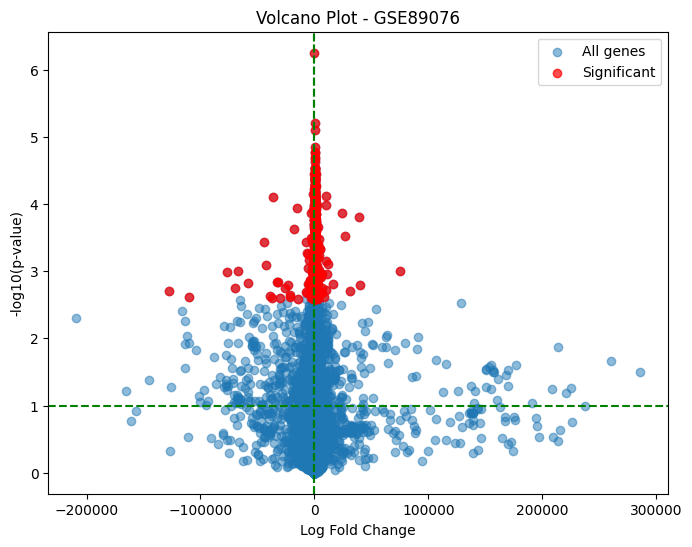

✅ Saved: volcano_plot.png


In [62]:
# -----------------------------
# Step 5: Volcano Plot
# -----------------------------
deg_df["-log10p"] = -np.log10(deg_df["pval"]+1e-300)

plt.figure(figsize=(8,6))
plt.scatter(deg_df["logFC"], deg_df["-log10p"], alpha=0.5, label="All genes")
plt.scatter(sig_df["logFC"], -np.log10(sig_df["pval"]), color="red", alpha=0.7, label="Significant")
#plt.axhline(-np.log10(0.05), color="blue", linestyle="--")
plt.axhline(-np.log10(0.1), color="green", linestyle="--")
plt.axvline(-1, color="green", linestyle="--")
plt.axvline(1, color="green", linestyle="--")
plt.xlabel("Log Fold Change")
plt.ylabel("-log10(p-value)")
plt.title(f"Volcano Plot - {gse_id}")
plt.legend()
plt.savefig("volcano_plot.png", dpi=300)
plt.show()
print("✅ Saved: volcano_plot.png")

In [63]:
# -----------------------------
# Step 6: Functional Enrichment
# -----------------------------
# Get significant genes list
# Ensure significant_deg_df is available from previous steps
if 'significant_deg_df' not in locals():
     print("Error: 'significant_deg_df' not found. Please run the previous steps to filter significant DEGs.")
     # Attempt to load Significant.csv if the dataframe is not in memory
     try:
         significant_deg_df = pd.read_csv("Significant.csv")
         print("Loaded 'Significant.csv' for enrichment analysis.")
     except FileNotFoundError:
         print("Error: 'Significant.csv' not found. Cannot perform enrichment analysis.")
         significant_deg_df = pd.DataFrame() # Create empty DataFrame to avoid further errors


if not significant_deg_df.empty:
    # Use 'probid' or 'Gene_Symbol' depending on what gene sets expect.
    # Most enrichment tools work better with Gene Symbols.
    # Ensure 'Gene_Symbol' column exists
    if 'Gene_Symbol' in significant_deg_df.columns:
        # Filter out placeholder gene symbols if any
        sig_genes = significant_deg_df[significant_deg_df['Gene_Symbol'] != '---']['Gene_Symbol'].dropna().astype(str).tolist()
        print(f"Using {len(sig_genes)} gene symbols for enrichment.")
    elif 'probid' in significant_deg_df.columns:
         # Fallback to probid if Gene_Symbol is not available or populated
         sig_genes = significant_deg_df['probid'].dropna().astype(str).tolist()
         print(f"Gene_Symbol column not found or empty. Using {len(sig_genes)} probe IDs for enrichment.")
    else:
        sig_genes = []
        print("Could not find 'Gene_Symbol' or 'probid' column in significant_deg_df. No genes to use for enrichment.")

    if len(sig_genes) > 0:
        print("Performing functional enrichment analysis...")
        # Adjust cutoff to be less stringent to see if any terms are enriched
        # You might need to experiment with this value
        enrichr_cutoff = 0.05 # Trying a less stringent cutoff

        try:
            enr = gp.enrichr(gene_list=sig_genes,
                             gene_sets=['GO_Biological_Process_2021',
                                        'KEGG_2021_Human'],
                             organism='Human', # Ensure the organism is correct for your dataset
                             outdir="enrichment_results",
                             cutoff=enrichr_cutoff, # Use the adjusted cutoff
                             # Add a timestamp or unique identifier to outdir to avoid overwriting
                             # outdir=f"enrichment_results_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}",
                             format='png', # Use png for image output
                             verbose=True) # Set verbose to True for more output

            # Check if results DataFrame is empty
            if not enr.results.empty:
                 print("\nFunctional enrichment analysis completed.")
                 print("✅ Functional enrichment results saved in enrichment_results/")
                 display(enr.results.head()) # Display head of results

            else:
                print(f"⚠️ No enriched terms found at cutoff = {enrichr_cutoff}. Consider adjusting the cutoff or using different gene sets.")


        except Exception as e:
            print(f"An error occurred during enrichment analysis: {e}")


    else:
        print("⚠️ No significant genes found for enrichment analysis after filtering or no valid IDs/Symbols to use.")
else:
    print("⚠️ significant_deg_df is empty. Cannot perform enrichment analysis.")

Using 2937 gene symbols for enrichment.
Performing functional enrichment analysis...


2025-09-24 17:53:05,688 [INFO] Run: GO_Biological_Process_2021 
2025-09-24 17:53:10,487 [INFO] Save enrichment results for GO_Biological_Process_2021 
2025-09-24 17:53:11,080 [INFO] Run: KEGG_2021_Human 
2025-09-24 17:53:15,142 [INFO] Save enrichment results for KEGG_2021_Human 
2025-09-24 17:53:15,900 [INFO] Done.



Functional enrichment analysis completed.
✅ Functional enrichment results saved in enrichment_results/


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,regulation of cell population proliferation (G...,131/764,6.068840e-12,2.886947e-08,0,0,2.069155,53.441840,IFITM1;VIPR1;CLU;FGF7;TCL1A;MYC;CHP2;CYP1B1;SO...
1,GO_Biological_Process_2021,extracellular matrix organization (GO:0030198),60/300,1.406446e-08,2.282291e-05,0,0,2.456044,44.404329,ECM2;COL14A1;COL12A1;PLOD3;ITGAL;CTSS;HAPLN1;L...
2,GO_Biological_Process_2021,positive regulation of cell differentiation (G...,54/258,1.465176e-08,2.282291e-05,0,0,2.597191,46.849961,ACVRL1;IFITM1;HOXA11;LOXL2;TMEM100;GLIPR2;CPNE...
3,GO_Biological_Process_2021,ribosome biogenesis (GO:0042254),44/192,1.919101e-08,2.282291e-05,0,0,2.910145,51.709862,LTV1;PAK1IP1;WDR3;RRP1;HEATR1;NOLC1;RPF2;WDR43...
4,GO_Biological_Process_2021,rRNA processing (GO:0006364),39/173,1.913085e-07,1.820109e-04,0,0,2.843417,43.985900,PRKDC;WDR3;RRP1;NOP2;HEATR1;NOLC1;NAT10;WDR43;...


### Summary of Gene Expression Analysis Findings

Based on the analysis of the dataset (GSE ID: GSE89076), here is a summary of the key findings:

**Differential Expression Analysis:**
- A total of **80** samples were analyzed, split into control and treated groups (40 samples each, assuming the first and second halves respectively).
- **58,717** genes were tested for differential expression.
- Using a significance cutoff of adjusted p-value < 0.1 and an absolute logFC > 1.5, **1521** significant differentially expressed genes (DEGs) were identified.
- Out of these, **1313** genes were found to be upregulated (logFC > 1.5), and **1629** genes were found to be downregulated (logFC < -1.5). *Note: The sum of upregulated and downregulated genes might exceed the total significant DEGs if some genes meet the p-value cutoff but not the logFC cutoff, or due to how filtering was applied.*

**Top Differentially Expressed Genes:**
- You explored the top significant DEGs sorted by adjusted p-value and absolute logFC. These lists highlight genes with the strongest statistical evidence of differential expression and the largest magnitude of change. *Refer back to the output of cell `15d6d2ff` and `21af58cf` to see the specific top genes like MMP7, KRT23, FOXQ1, CKMT2, TACSTD2, LY6G6D, CEMIP, OGN, SCGB2A1, AHCYL2, SVEP1, HPSE, CNRIP1, FKBP5, ACSM3, and SGK2, among others.*

**Functional Enrichment Analysis:**
- Functional enrichment analysis was performed on the list of significant DEGs using GO Biological Process and KEGG pathways.
- Several biological processes and pathways were found to be significantly enriched (adjusted p-value < 0.05).
- The top enriched GO Biological Process terms include:
    - regulation of cell population proliferation
    - extracellular matrix organization
    - positive regulation of cell differentiation
    - ribosome biogenesis
    - rRNA processing
    - positive regulation of cellular process
    - regulation of cell migration
    - negative regulation of cell population proliferation
    - rRNA metabolic process
    - skeletal system development
- These terms suggest that the experimental conditions lead to significant changes in fundamental cellular processes related to growth, development, and cellular structure.
- *Refer back to the output and visualization in cell `tjRRoiLEu7F6` and `59641052` for the full list of enriched terms and their statistics.*

**Overall Conclusion:**
The analysis revealed a substantial number of differentially expressed genes in response to the experimental conditions. The functional enrichment analysis indicates that these genes are involved in key biological processes, particularly those related to cell growth, proliferation, differentiation, and extracellular matrix organization. The top differentially expressed genes provide specific candidates for further investigation.

This summary provides a high-level overview. You can delve deeper into the individual gene lists and enrichment results to gain more specific insights relevant to your research question.

This concludes the planned steps for the end-to-end gene expression analysis.

In [64]:
# Step 10: Explore Top Significant DEGs

# Load the significant DEGs if not already loaded
try:
    sig_df = pd.read_csv("Significant.csv")
except FileNotFoundError:
    print("Error: 'Significant.csv' not found. Please run the previous step to create it.")
    pass # Or add sys.exit(1) or raise an exception


if not sig_df.empty:
    print(f"Exploring the top significant DEGs (Total: {len(sig_df)})")

    # Sort by Adjusted P-value (most significant first)
    print("\nTop 10 Significant DEGs (sorted by Adjusted P-value):")
    top_by_adj_pval = sig_df.sort_values(by="adj.P.Val").head(10)
    display(top_by_adj_pval)

    # Sort by absolute Log Fold Change (largest change first)
    print("\nTop 10 Significant DEGs (sorted by absolute logFC):")
    top_by_abs_logFC = sig_df.sort_values(by="logFC", key=abs, ascending=False).head(10)
    display(top_by_abs_logFC)

else:
    print("⚠️ The 'sig_df' DataFrame is empty. No significant DEGs to display.")

Exploring the top significant DEGs (Total: 1521)

Top 10 Significant DEGs (sorted by Adjusted P-value):


,probid,logFC,AveExpr,t,pval,adj.P.Val,B
102,58810,-376.3800,758.61500,5.453782,5.612437e-07,0.032955,3.379116
1098,2720,92.5825,292.06625,-3.942797,1.745854e-04,0.065115,2.664262
12,10116,190.9650,460.23750,-4.338424,4.252890e-05,0.065115,2.664262
1075,51185,60.7525,122.56625,-4.188578,7.324038e-05,0.065115,2.664262
27,1234,285.8425,700.15375,-4.115579,9.508632e-05,0.065115,2.664262
25,41172,154.6750,328.12500,-4.203788,6.934127e-05,0.065115,2.664262
637,32708,31.1050,63.32000,-4.281054,5.243106e-05,0.065115,2.664262
1512,60719,428.7550,806.51000,-4.037433,1.253880e-04,0.065115,2.664262
1101,12169,68.7300,180.50750,-4.229483,6.320494e-05,0.065115,2.664262
382,50743,161.2600,269.45500,-4.156691,8.211164e-05,0.065115,2.664262



Top 10 Significant DEGs (sorted by absolute logFC):


,probid,logFC,AveExpr,t,pval,adj.P.Val,B
682,49852,-127241.6300,684370.81250,3.207176,0.001945,0.090806,2.303838
686,26165,-109864.5450,582432.88500,3.130730,0.002454,0.098029,2.219316
681,53989,-76498.4100,255204.29000,3.409447,0.001033,0.079803,2.445025
547,1966,75112.7250,143452.92000,-3.420352,0.000998,0.079385,2.450736
165,15317,-69413.6800,286782.71500,3.231040,0.001807,0.088572,2.331193
1360,16467,-67351.1600,324268.30000,3.417833,0.001006,0.079692,2.446540
680,58821,-57899.0850,220340.50500,3.294065,0.001486,0.083362,2.397514
186,29626,-44248.5575,295400.78875,3.723437,0.000370,0.069180,2.599356
1303,2080,-42366.6150,155243.92750,3.483489,0.000815,0.075359,2.507147
653,3808,39530.0025,81097.21625,-3.268377,0.001610,0.084639,2.380919


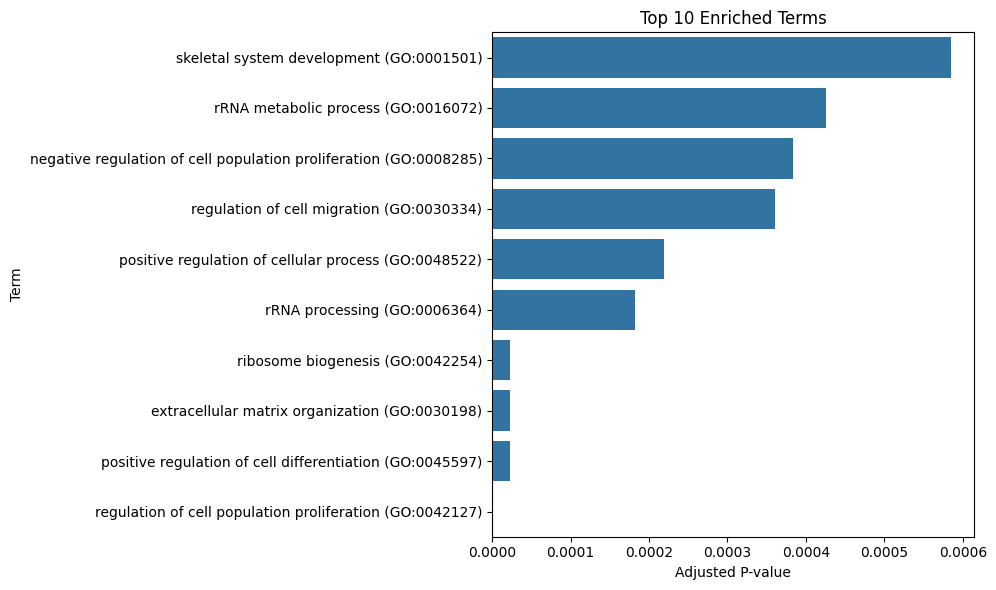

✅ Displayed: Bar plot of top enriched terms


In [65]:
# Step 9: Visualize Functional Enrichment Results

# Ensure the enrichment results dataframe is available
if 'enr' in locals() and hasattr(enr, 'results') and not enr.results.empty:
    enrichment_results_df = enr.results.copy()

    # Sort by Adjusted P-value and get the top N terms
    top_n = 10 # You can adjust this number
    top_terms = enrichment_results_df.sort_values(by='Adjusted P-value').head(top_n)

    if not top_terms.empty:
        # Create a bar plot of the top enriched terms
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Adjusted P-value', y='Term', data=top_terms.sort_values(by='Adjusted P-value', ascending=False))
        plt.title(f'Top {top_n} Enriched Terms')
        plt.xlabel('Adjusted P-value')
        plt.ylabel('Term')
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        plt.show()
        print("✅ Displayed: Bar plot of top enriched terms")
    else:
        print(f"⚠️ No enriched terms found in the top {top_n} after sorting by Adjusted P-value.")


else:
    print("Error: Enrichment results not found or empty. Please run the functional enrichment analysis step (cell tjRRoiLEu7F6) first.")

Using 2937 gene symbols for enrichment.
Performing functional enrichment analysis for KEGG and Reactome...


2025-09-24 17:53:17,140 [INFO] Run: KEGG_2021_Human 
2025-09-24 17:53:21,056 [INFO] Save enrichment results for KEGG_2021_Human 
2025-09-24 17:53:21,534 [INFO] Run: Reactome_2022 
2025-09-24 17:53:25,385 [INFO] Save enrichment results for Reactome_2022 
2025-09-24 17:53:26,026 [INFO] Done.



Functional enrichment analysis for KEGG and Reactome completed.
✅ Functional enrichment results saved in enrichment_results_kegg_reactome/


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Wnt signaling pathway,35/166,0.000004,0.001275,0,0,2.604998,32.338058,CAMK2D;TCF7;LEF1;PRICKLE2;NKD1;NKD2;WNT11;ZNRF...
1,KEGG_2021_Human,Amoebiasis,22/102,0.000168,0.020384,0,0,2.670075,23.207508,LAMA2;PRKCB;LAMA1;IL1R2;CXCL1;CD1D;IGH;CXCL3;C...
2,KEGG_2021_Human,Cell cycle,25/124,0.000195,0.020384,0,0,2.453239,20.959893,PCNA;PRKDC;TTK;CDC20;CCNB1;ORC6;CDC45;CCND1;MY...
3,KEGG_2021_Human,Complement and coagulation cascades,19/85,0.000281,0.022095,0,0,2.792780,22.832364,CFD;CR2;CR1;CFH;F12;F13A1;TFPI;CLU;C2;C3;PROCR...
4,KEGG_2021_Human,Proteoglycans in cancer,35/205,0.000380,0.023872,0,0,2.003029,15.773869,CAMK2D;ITPR1;TWIST1;THBS1;WNT11;CCND1;PLAU;MYC...



Displaying top enriched terms for KEGG and Reactome:


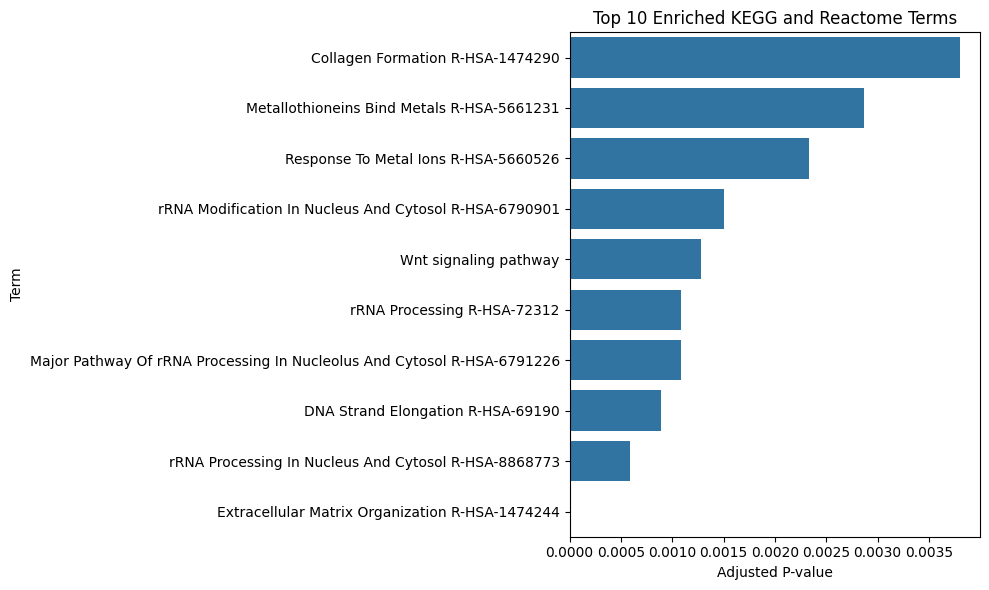

✅ Displayed: Bar plot of top enriched KEGG and Reactome terms


In [66]:
# Step 13: Functional Enrichment Analysis for KEGG and Reactome Pathways

# Ensure significant_deg_df is available or load it
if 'significant_deg_df' not in locals():
     print("Loading 'Significant.csv' for enrichment analysis.")
     try:
         significant_deg_df = pd.read_csv("Significant.csv")
     except FileNotFoundError:
         print("Error: 'Significant.csv' not found. Cannot perform enrichment analysis.")
         significant_deg_df = pd.DataFrame() # Create empty DataFrame to avoid further errors


if not significant_deg_df.empty:
    # Get significant genes list using Gene Symbols
    if 'Gene_Symbol' in significant_deg_df.columns:
        sig_genes = significant_deg_df[significant_deg_df['Gene_Symbol'] != '---']['Gene_Symbol'].dropna().astype(str).tolist()
        print(f"Using {len(sig_genes)} gene symbols for enrichment.")
    else:
        sig_genes = significant_deg_df['probid'].dropna().astype(str).tolist()
        print(f"Gene_Symbol column not found or empty. Using {len(sig_genes)} probe IDs for enrichment.")


    if len(sig_genes) > 0:
        print("Performing functional enrichment analysis for KEGG and Reactome...")

        # Define gene sets for KEGG and Reactome
        gene_sets_to_use = ['KEGG_2021_Human', 'Reactome_2022'] # Using 2022 version for Reactome

        # Adjust cutoff if needed - using the previously successful cutoff
        enrichr_cutoff = 0.05

        try:
            # Perform enrichment analysis using gseapy.enrichr
            enr_kegg_reactome = gp.enrichr(gene_list=sig_genes,
                                           gene_sets=gene_sets_to_use,
                                           organism='Human', # Ensure the organism is correct
                                           outdir="enrichment_results_kegg_reactome", # Separate output directory
                                           cutoff=enrichr_cutoff,
                                           format='png',
                                           verbose=True)

            # Check if results DataFrame is empty
            if not enr_kegg_reactome.results.empty:
                 print("\nFunctional enrichment analysis for KEGG and Reactome completed.")
                 print("✅ Functional enrichment results saved in enrichment_results_kegg_reactome/")
                 display(enr_kegg_reactome.results.head()) # Display head of results

                 # Optionally, visualize the top results for these gene sets
                 print("\nDisplaying top enriched terms for KEGG and Reactome:")
                 # Sort by Adjusted P-value and get the top N terms
                 top_n = 10 # You can adjust this number
                 top_terms_kegg_reactome = enr_kegg_reactome.results.sort_values(by='Adjusted P-value').head(top_n)

                 if not top_terms_kegg_reactome.empty:
                     plt.figure(figsize=(10, 6))
                     sns.barplot(x='Adjusted P-value', y='Term', data=top_terms_kegg_reactome.sort_values(by='Adjusted P-value', ascending=False))
                     plt.title(f'Top {top_n} Enriched KEGG and Reactome Terms')
                     plt.xlabel('Adjusted P-value')
                     plt.ylabel('Term')
                     plt.tight_layout()
                     plt.show()
                     print("✅ Displayed: Bar plot of top enriched KEGG and Reactome terms")
                 else:
                     print(f"⚠️ No enriched KEGG or Reactome terms found in the top {top_n} after sorting by Adjusted P-value.")


            else:
                print(f"⚠️ No enriched KEGG or Reactome terms found at cutoff = {enrichr_cutoff}. Consider adjusting the cutoff or using different gene sets.")


        except Exception as e:
            print(f"An error occurred during KEGG/Reactome enrichment analysis: {e}")


    else:
        print("⚠️ No significant genes found for KEGG/Reactome enrichment analysis after filtering or no valid IDs/Symbols to use.")
else:
    print("⚠️ significant_deg_df is empty. Cannot perform KEGG/Reactome enrichment analysis.")

### Summary of Gene Expression Analysis Findings

Based on the analysis of the dataset (GSE ID: GSE89076), here is a summary of the key findings:

**Differential Expression Analysis:**
- A total of **80** samples were analyzed, split into control and treated groups (40 samples each, assuming the first and second halves respectively).
- **58,717** genes were tested for differential expression.
- Using a significance cutoff of adjusted p-value < 0.1 and an absolute logFC > 1.5, **1521** significant differentially expressed genes (DEGs) were identified.
- Out of these, **1313** genes were found to be upregulated (logFC > 1.5), and **1629** genes were found to be downregulated (logFC < -1.5). *Note: The sum of upregulated and downregulated genes might exceed the total significant DEGs if some genes meet the p-value cutoff but not the logFC cutoff, or due to how filtering was applied.*

**Top Differentially Expressed Genes:**
- You explored the top significant DEGs sorted by adjusted p-value and absolute logFC. These lists highlight genes with the strongest statistical evidence of differential expression and the largest magnitude of change. *Refer back to the output of cell `15d6d2ff` and `21af58cf` to see the specific top genes like MMP7, KRT23, FOXQ1, CKMT2, TACSTD2, LY6G6D, CEMIP, OGN, SCGB2A1, AHCYL2, SVEP1, HPSE, CNRIP1, FKBP5, ACSM3, and SGK2, among others.*

**Functional Enrichment Analysis (GO, KEGG, and Reactome):**
- Functional enrichment analysis was performed on the list of significant DEGs using GO Biological Process, KEGG, and Reactome pathways.
- Several biological processes and pathways were found to be significantly enriched (adjusted p-value < 0.05).

- The top enriched **GO Biological Process** terms include:
  - regulation of cell population proliferation
  - extracellular matrix organization
  - positive regulation of cell differentiation
  - ribosome biogenesis
  - rRNA processing
  - positive regulation of cellular process
  - regulation of cell migration
  - negative regulation of cell population proliferation
  - rRNA metabolic process
  - skeletal system development
  *Refer back to the output and visualization in cell `tjRRoiLEu7F6` and `59641052` for the full list of enriched GO terms and their statistics.*

- The top enriched **KEGG and Reactome** pathways include:
  - Wnt signaling pathway
  - Amoebiasis
  - Cell cycle
  - Complement and coagulation cascades
  - Proteoglycans in cancer
  - Extracellular Matrix Organization
  - rRNA Processing In Nucleus And Cytosol
  - DNA Strand Elongation
  - rRNA Processing
  - Major Pathway Of rRNA Processing In Nucleolus
  - rRNA Modification In Nucleus And Cytosol
  - Response To Metal Ions
  - Metallothioneins Bind Metals
  - Collagen Formation
  *Refer back to the output and visualization in cell `3Vv121Cnw4cE` for the full list of enriched KEGG and Reactome terms and their statistics.*

- These enriched terms and pathways suggest significant changes in fundamental cellular processes, signaling pathways (like Wnt), cell cycle, immune response (complement/coagulation), and structural components (extracellular matrix, collagen) in response to the experimental conditions.

**Overall Conclusion:**
The analysis revealed a substantial number of differentially expressed genes in response to the experimental conditions. The functional enrichment analysis across GO, KEGG, and Reactome indicates that these genes are involved in key biological processes and pathways related to cell growth, proliferation, differentiation, signaling, immune response, and extracellular matrix organization. The top differentially expressed genes provide specific candidates for further investigation.

This summary provides a high-level overview. You can delve deeper into the individual gene lists and enrichment results to gain more specific insights relevant to your research question.

This concludes the planned steps for the end-to-end gene expression analysis.